# ML Results Visualization

Visualization notebook for ML batch evaluation results stored in S3 machine-learning structure.

S3 Structure: {save_result_path}/machine-learning/{experiment_type}/{model_name}/
├── results.pkl            # Full evaluation results DataFrame
├── summary-stats.csv      # Aggregated statistics
├── run-metadata.yml       # Run configuration and metadata
└── failed-tasks.csv       # Tasks that failed during processing (if any)

## Configuration

In [114]:
# Configuration variables - simplified for one model and one experiment
EXPERIMENT_TYPE = "parameter-distortion-v2"  # Single experiment type
MODEL_NAME = "sy_simple"  # Single model name

# Experiment type mapping to perturbation column names
PERTURBATION_MAPPING = {
    "expression-noise-v1": "Expression Noise Level",
    "parameter-distortion-v2": "Distortion Factor", 
    "response-noise-v1": "Response Noise Level"
}

# Visualization settings
PLOT_STYLE = "whitegrid"
FONT_SCALE = 1.2
FIGURE_SIZE = (10, 4)

## Initialization

In [115]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional, Any, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set up project path - same pattern as robustness notebooks
path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path + "/src")
print(f"✅ Project path set to: {os.getcwd()}")

# Set up plotting style
sns.set_style(PLOT_STYLE)
sns.set_context("talk", font_scale=FONT_SCALE)

# Import S3ConfigManager
from models.utils.s3_config_manager import S3ConfigManager

# Initialize S3 manager
s3_manager = S3ConfigManager()
print(f"✅ S3 connection established. Save result path: {s3_manager.save_result_path}")

✅ Project path set to: c:\Github\new-peak-project\src
✅ S3 connection successful. Bucket: bio-data
✅ S3 connection established. Save result path: new-peak-project/experiments/ch5-paper


## Data Loading Functions

In [116]:
def load_ml_results(experiment_type: str, model_name: str) -> Optional[pd.DataFrame]:
    """
    Load ML results from S3 for a specific experiment and model.
    
    Args:
        experiment_type: Type of experiment (e.g., "expression_noise_v1")
        model_name: Name of the model (e.g., "sy_simple")
        
    Returns:
        DataFrame with results or None if loading fails
    """
    base_path = f"{s3_manager.save_result_path}/machine-learning"
    results_path = f"{base_path}/{experiment_type}/{model_name}/results.pkl"
    
    try:
        results_df = s3_manager.load_data_from_path(results_path, data_format="pkl")
        print(f"✅ Loaded results: {experiment_type}/{model_name} ({len(results_df)} rows)")
        
        # Add experiment type and model name if not present
        if "experiment_type" not in results_df.columns:
            results_df["experiment_type"] = experiment_type
        if "model_name" not in results_df.columns:
            results_df["model_name"] = model_name
            
        return results_df
    except Exception as e:
        print(f"❌ Error loading results for {experiment_type}/{model_name}: {e}")
        return None


def load_and_prepare_data() -> Optional[pd.DataFrame]:
    """
    Load and prepare data for visualization.
    
    Returns:
        Prepared DataFrame or None if loading fails
    """
    print(f"📊 Loading data for experiment: {EXPERIMENT_TYPE}, model: {MODEL_NAME}")
    
    # Load results
    results_df = load_ml_results(EXPERIMENT_TYPE, MODEL_NAME)
    if results_df is None:
        return None
    return results_df

## Load Data

In [117]:
# Load and prepare data
data_df = load_and_prepare_data()



📊 Loading data for experiment: parameter-distortion-v2, model: sy_simple


✅ Loaded results: parameter-distortion-v2/sy_simple (1350 rows)


In [118]:
data_df

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value,experiment_type,model_name,evaluation_timestamp
0,Linear Regression,features_0,645.880171,0.150982,0.400342,1.230718e-15,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708
1,Linear Regression,features_0,469.660872,0.158502,0.402155,8.914339e-16,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708
2,Linear Regression,features_0,420.500010,0.207259,0.455810,2.489469e-20,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708
3,Linear Regression,features_0,540.096908,0.157375,0.398188,1.801051e-15,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708
4,Linear Regression,features_0,566.313475,0.186446,0.433616,2.390652e-18,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708
...,...,...,...,...,...,...,...,...,...
1345,Neural Network,original_plus_last_with_outcome_1.0,671.287505,0.117584,0.362917,6.268669e-13,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708
1346,Neural Network,original_plus_last_with_outcome_1.0,522.395996,0.064015,0.362862,6.322922e-13,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708
1347,Neural Network,original_plus_last_with_outcome_1.0,11140.401006,-20.002270,0.055922,2.839811e-01,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708
1348,Neural Network,original_plus_last_with_outcome_1.0,582.828274,0.090708,0.353972,2.477417e-12,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708


In [119]:
data_df['Feature Data'].unique()

array(['features_0', 'dynamic_features_0',
       'dynamic_features_no_outcome_0', 'last_time_points_0',
       'last_time_points_no_outcome_0',
       'original_plus_dynamic_no_outcome_0',
       'original_plus_last_no_outcome_0',
       'original_plus_dynamic_with_outcome_0',
       'original_plus_last_with_outcome_0', 'features_0.1',
       'dynamic_features_0.1', 'dynamic_features_no_outcome_0.1',
       'last_time_points_0.1', 'last_time_points_no_outcome_0.1',
       'original_plus_dynamic_no_outcome_0.1',
       'original_plus_last_no_outcome_0.1',
       'original_plus_dynamic_with_outcome_0.1',
       'original_plus_last_with_outcome_0.1', 'features_0.2',
       'dynamic_features_0.2', 'dynamic_features_no_outcome_0.2',
       'last_time_points_0.2', 'last_time_points_no_outcome_0.2',
       'original_plus_dynamic_no_outcome_0.2',
       'original_plus_last_no_outcome_0.2',
       'original_plus_dynamic_with_outcome_0.2',
       'original_plus_last_with_outcome_0.2', 'features

In [120]:
def add_feature_metadata_columns(df, column="Feature Data"):
    """
    Add 'feature_data_type' and 'noise_level' columns to DataFrame.
    Splits at the last underscore where the part after is a number.
    Converts noise_level to float type.

    Parameters:
    -----------
    df : DataFrame
        Input DataFrame
    column : str
        Column name containing the feature strings

    Returns:
    --------
    DataFrame with two additional columns
    """
    # Copy the DataFrame to avoid modifying the original
    result_df = df.copy()

    # Initialize new columns
    feature_types = []
    noise_levels = []

    for value in df[column]:
        value_str = str(value)

        # Initialize with original value and None
        feature_type = value_str
        noise_level = None

        # Find the last underscore
        last_underscore_pos = value_str.rfind("_")

        if last_underscore_pos != -1:
            # Split at the last underscore
            possible_feature = value_str[:last_underscore_pos]
            possible_noise = value_str[last_underscore_pos + 1 :]

            # Check if the part after the last underscore is a number
            try:
                # Try to convert to float
                noise_float = float(possible_noise)
                # If successful, this is the noise level
                feature_type = possible_feature
                noise_level = noise_float
            except ValueError:
                # Not a number, keep original values
                pass

        feature_types.append(feature_type)
        noise_levels.append(noise_level)

    # Add the new columns
    result_df["feature_data_type"] = feature_types
    result_df["noise_level"] = noise_levels

    return result_df



In [121]:
processed_df = add_feature_metadata_columns(data_df, column='Feature Data')

In [122]:
processed_df

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value,experiment_type,model_name,evaluation_timestamp,feature_data_type,noise_level
0,Linear Regression,features_0,645.880171,0.150982,0.400342,1.230718e-15,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708,features,0.0
1,Linear Regression,features_0,469.660872,0.158502,0.402155,8.914339e-16,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708,features,0.0
2,Linear Regression,features_0,420.500010,0.207259,0.455810,2.489469e-20,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708,features,0.0
3,Linear Regression,features_0,540.096908,0.157375,0.398188,1.801051e-15,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708,features,0.0
4,Linear Regression,features_0,566.313475,0.186446,0.433616,2.390652e-18,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708,features,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1345,Neural Network,original_plus_last_with_outcome_1.0,671.287505,0.117584,0.362917,6.268669e-13,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708,original_plus_last_with_outcome,1.0
1346,Neural Network,original_plus_last_with_outcome_1.0,522.395996,0.064015,0.362862,6.322922e-13,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708,original_plus_last_with_outcome,1.0
1347,Neural Network,original_plus_last_with_outcome_1.0,11140.401006,-20.002270,0.055922,2.839811e-01,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708,original_plus_last_with_outcome,1.0
1348,Neural Network,original_plus_last_with_outcome_1.0,582.828274,0.090708,0.353972,2.477417e-12,parameter-distortion-v2,sy_simple,2026-01-04T04:36:38.400708,original_plus_last_with_outcome,1.0


In [123]:
processed_df['feature_data_type'].unique()  

array(['features', 'dynamic_features', 'dynamic_features_no_outcome',
       'last_time_points', 'last_time_points_no_outcome',
       'original_plus_dynamic_no_outcome',
       'original_plus_last_no_outcome',
       'original_plus_dynamic_with_outcome',
       'original_plus_last_with_outcome'], dtype=object)

In [124]:
processed_df["noise_level"].unique()

array([0. , 0.1, 0.2, 0.3, 0.5, 1. ])

In [125]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model                 1350 non-null   object 
 1   Feature Data          1350 non-null   object 
 2   Mean Squared Error    1350 non-null   float64
 3   R2 Score              1350 non-null   float64
 4   Pearson Correlation   1350 non-null   float64
 5   Pearson P-Value       1350 non-null   float64
 6   experiment_type       1350 non-null   object 
 7   model_name            1350 non-null   object 
 8   evaluation_timestamp  1350 non-null   object 
 9   feature_data_type     1350 non-null   object 
 10  noise_level           1350 non-null   float64
dtypes: float64(5), object(6)
memory usage: 116.1+ KB


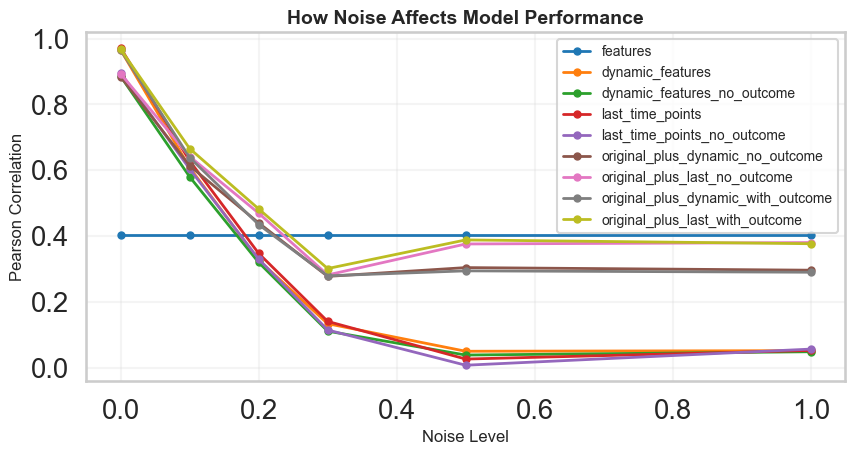

In [126]:
def create_single_plot(df):
    """
    Create one simple but informative plot.
    """
    fig, ax = plt.subplots(figsize=(9, 5))

    # 2. Plot each feature type with thinner lines
    for feature_type in df["feature_data_type"].unique():
        feature_data = df[df["feature_data_type"] == feature_type]
        avg_data = (
            feature_data.groupby("noise_level")["Pearson Correlation"]
            .mean()
            .reset_index()
        )

        ax.plot(
            avg_data["noise_level"],
            avg_data["Pearson Correlation"],
            marker="o",
            linewidth=2,
            markersize=5,
            label=feature_type,
        )

    # Customize
    ax.set_xlabel("Noise Level", fontsize=12)
    ax.set_ylabel("Pearson Correlation", fontsize=12)
    ax.set_title("How Noise Affects Model Performance", fontsize=14, fontweight="bold")
    ax.grid(True, alpha=0.2)
    ax.legend(fontsize=10)

    plt.tight_layout()
    return fig, ax


# Use it like this:
fig, ax = create_single_plot(processed_df)
plt.show()



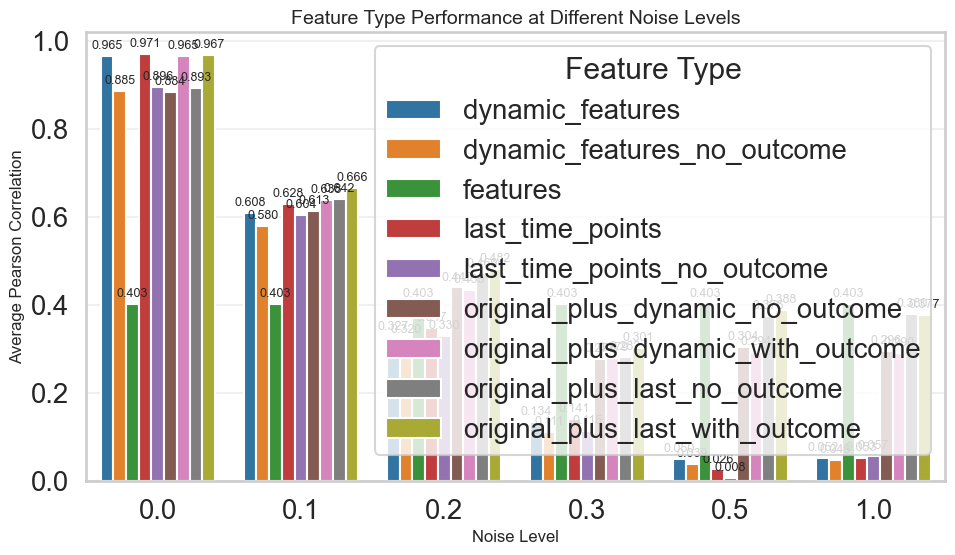

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_feature_type_comparison(df, metric="Mean Squared Error", figsize=(10, 6)):
    """
    Bar chart comparing feature types at each noise level.
    Shows which feature types perform best/worst at different noise levels.
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate average metric for each feature type at each noise level
    pivot_data = (
        df.groupby(["noise_level", "feature_data_type"])[metric].mean().reset_index()
    )

    # Create grouped bar chart
    sns.barplot(
        data=pivot_data, x="noise_level", y=metric, hue="feature_data_type", ax=ax
    )

    # Customize
    ax.set_xlabel("Noise Level", fontsize=12)
    ax.set_ylabel(f"Average {metric}", fontsize=12)
    ax.set_title(f"Feature Type Performance at Different Noise Levels", fontsize=14)
    ax.grid(True, alpha=0.3, axis="y")
    ax.legend(title="Feature Type")

    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", padding=3, fontsize=9)

    plt.tight_layout()
    return fig, ax


# Usage:
fig, ax = plot_feature_type_comparison(processed_df, metric="Pearson Correlation")
plt.show()

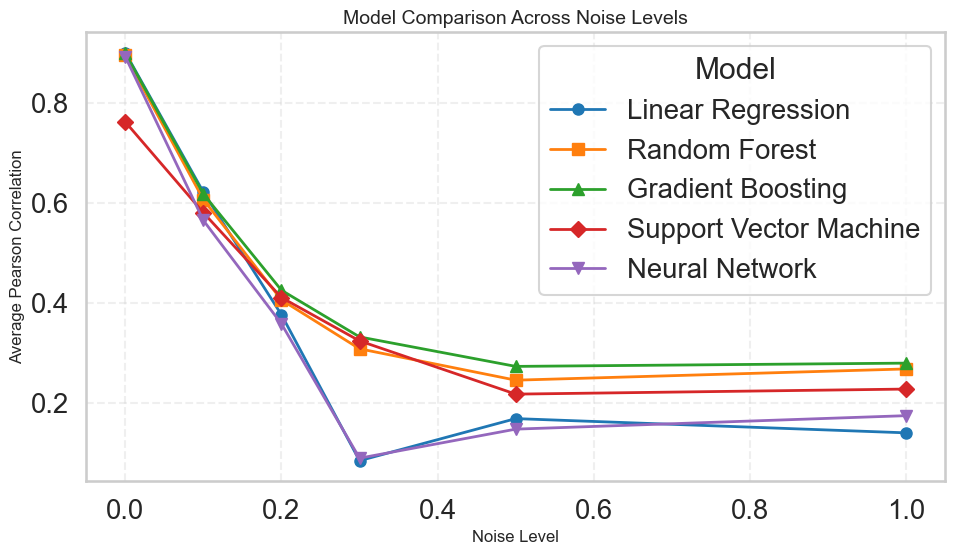

In [128]:
import matplotlib.pyplot as plt


def plot_model_comparison(df, metric="Mean Squared Error", figsize=(10, 6)):
    """
    Line chart comparing different models' performance across noise levels.
    Shows which models are most robust to noise.
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Get unique models
    models = df["Model"].unique()

    # Different markers for each model
    markers = ["o", "s", "^", "D", "v", "p", "*", "h", "X", "P"]

    for i, model in enumerate(models):
        # Get data for this model
        model_data = df[df["Model"] == model]

        # Calculate average metric at each noise level
        avg_by_noise = model_data.groupby("noise_level")[metric].mean().reset_index()

        # Plot with different marker
        marker = markers[i % len(markers)]
        ax.plot(
            avg_by_noise["noise_level"],
            avg_by_noise[metric],
            marker=marker,
            linewidth=2,
            markersize=8,
            label=model,
        )

    # Customize
    ax.set_xlabel("Noise Level", fontsize=12)
    ax.set_ylabel(f"Average {metric}", fontsize=12)
    ax.set_title(f"Model Comparison Across Noise Levels", fontsize=14)
    ax.grid(True, alpha=0.3, linestyle="--")
    ax.legend(title="Model")

    plt.tight_layout()
    return fig, ax


# Usage:
fig, ax = plot_model_comparison(processed_df, metric='Pearson Correlation')
plt.show()